<a href="https://www.kaggle.com/code/shokhjahonisroilov/help-bobai?scriptVersionId=294163657" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="./figs/IOAI-Logo.png" alt="IOAI Logo" width="200" height="auto">

[IOAI 2024 (Burgas, Bulgaria), On-Site Round](https://ioai-official.org/bulgaria-2024)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IOAI-official/IOAI-2024/blob/main/On-Site-Round/Help_BOBAI/Help_BOBAI.ipynb)

# Help BOBAI: More classification in an unknown language

<img src="./figs/Help BOBAI Fig 1.png" width="700">

## Background
Last time you heard from Bob, he asked you to help him by building a classifier for a new unknown language. The client, Amoira, was happy with your solution so Bob instructed his team to deploy the new model and after some heavy optimization and careful unit testing, the service was deployed and has been running smoothly since.

## Task

This very morning, Amoira returned with a request to extend the number of classes which the classifier can handle from 5 to 7. And this has to be done *today*!

Amoira has provided labeled data for the new classes. With more time, Bob could just use your earlier solution to train a new model on the union of the old and new data, right? The trouble is that the deployment of a new model is a complex process and cannot be done in a day, so the solution has to be built entirely around the model already deployed. Bob has once more come to you for help, as you know the task best.

Whatsmore, Amoira's security concerns have grown even further with the addition of the new data, so they have requested that Bob does not release the text in any form - what if someone managed to decrypt it! So Bob has provided you with a precomputed and cached encoding of all available data: the train and dev set previously used for the 5-way classification, and the new data Amoira provided for the 2 additional classes. The encoding is the output of the pooling layer in mBERT, so is fits right into the classifier previously trained.

Your task is to build a solution for 7-way classification, while operating within the following constraints:

*   The solution can use the 5-way classifier, but cannot change the parameters of the classifier or add any new learned parameters.

*   You are allowed to compute averages and distances between the data encodings.

*   The solution should be reproducible in under 1 hour on an L4 GPU card.

*   The classifier has to perform inference on any random 500 data samples in under 2 minutes on an L4 GPU card.

## Deliverables

You need to submit:

*   Working code that can be used to reproduce and test your best model.
  * In this Colab notebook.
  * Reproducing your best model means that starting from the baseline classifier, we should be able to arrive at your final best model by executing the cells of the notebook.
*   The predictions on the test data (released two hours before the end of the competition).

**You absolutely need to ensure that:**

(1) your notebook is executable from top to bottom

(2) that the notebook contains the full code needed to reproduce your model

(3) that it can run on an L4 GPU



## Training Dataset

In [5]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.decomposition import PCA
import random
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd

In [6]:
dataset = torch.load('/kaggle/input/bobai-data/train-dev_dataset_with_labels.pt')

inputs = dataset[:,:,:-1]
labels = dataset[:, :, -1]


In [7]:
points = [inputs[labels == c] for c in range(7)]

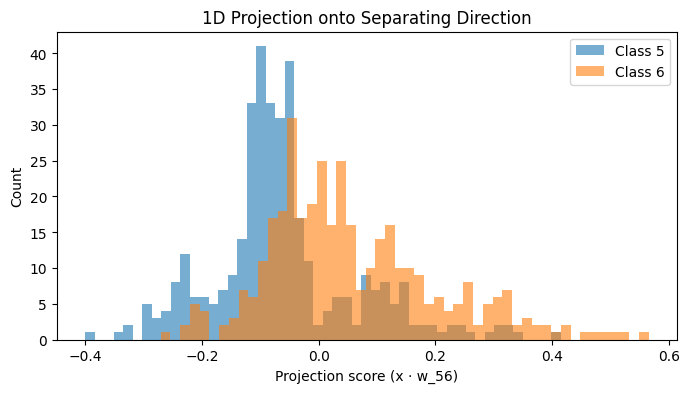

In [8]:
y = labels.squeeze()
x = inputs.squeeze(1)

mask_new = (y == 5) | (y == 6)
X_56 = x[mask_new]
y_56 = y[mask_new]

# normalize embeddings
X_56 = F.normalize(X_56, dim=1)

# compute w_56
c5 = F.normalize(X_56[y_56 == 5].mean(dim=0), dim=0)
c6 = F.normalize(X_56[y_56 == 6].mean(dim=0), dim=0)
w_56 = F.normalize(c6 - c5, dim=0)

# projection scores
scores = X_56 @ w_56

# plotting (fixed indexing)
scores_5 = scores[y_56 == 5].detach().cpu().numpy()
scores_6 = scores[y_56 == 6].detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.hist(scores_5, bins=50, alpha=0.6, label="Class 5")
plt.hist(scores_6, bins=50, alpha=0.6, label="Class 6")
plt.xlabel("Projection score (x · w_56)")
plt.ylabel("Count")
plt.legend()
plt.title("1D Projection onto Separating Direction")
plt.show()


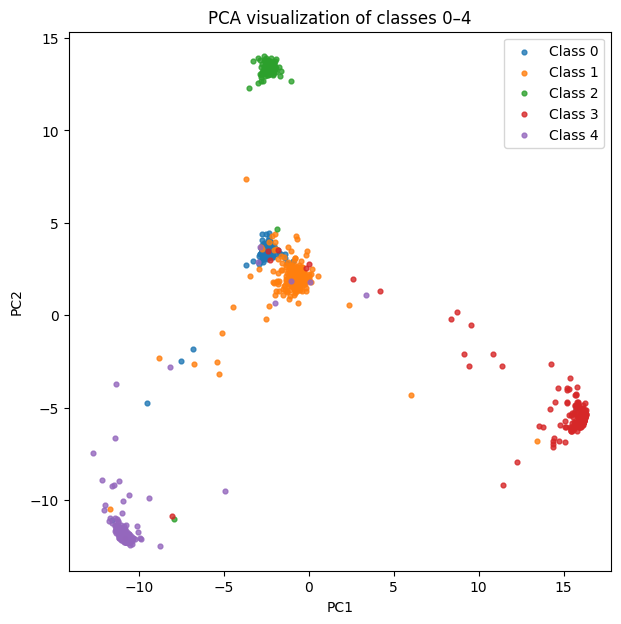

In [9]:
points_04 = [points[c].squeeze(1) for c in range(5)]  
X_all = torch.cat(points_04, dim=0)
X_2d = PCA(n_components=100).fit_transform(X_all.cpu().numpy())

sizes = [len(p) for p in points_04]

X_2d_by_class = []
start = 0
for size in sizes:
    X_2d_by_class.append(X_2d[start:start + size])
    start += size

plt.figure(figsize=(7, 7))
colors = ["tab:blue", "tab:orange", "tab:green",
          "tab:red", "tab:purple"]

for c, Xc in enumerate(X_2d_by_class):
    plt.scatter(
        Xc[:, 0],
        Xc[:, 1],
        s=12,
        color=colors[c],
        label=f"Class {c}",
        alpha=0.8
    )

plt.legend()
plt.title("PCA visualization of classes 0–4")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Baseline Solution

Below you will find a very naive baseline solution: given an input vector, we use either randomly assign one of the new labels (5 and 6) with uniform probability over a 7-way classification, or we use the base classifier to make a prediction.

You can replace the code below with your solution.

In [10]:
class SevenWayClassifier():
  def __init__(self):
    base_clf = torch.nn.Linear(in_features=768, out_features=5)
    base_clf.load_state_dict(torch.load("/kaggle/input/bobai-data/base_classifier.pth"))
    self.base_clf = base_clf

    X = inputs.squeeze(1)         
    y = labels.squeeze()         
    
    X = F.normalize(X, dim=1)
    old_mask = y < 5
    
    self.old_X = X[old_mask]       
    self.old_y = y[old_mask]    
      
    mask_new = (y == 5) | (y == 6)
    X_new = X[mask_new]     
    y_new = y[mask_new]     

    
    c5 = X_new[y_new == 5].mean(dim=0)
    c6 = X_new[y_new == 6].mean(dim=0)
    
    self.w_56 = F.normalize(c6 - c5, dim=0) 
    self.t_56 = 0.5 * (
        (X_new[y_new == 5] @ self.w_56).mean() +
        (X_new[y_new == 6] @ self.w_56).mean()
    )


  def base_classification(self, input_vector):

    with torch.no_grad():
      logits = self.base_clf(input_vector)
      preds = torch.softmax(logits, 1)
      predicted_class = preds.argmax(dim=1).numpy()[0]
        
    return predicted_class


  def knn_old_class_score(self, x, k=15):
    # cosine similarity since vectors are normalized
    sims = torch.matmul(x, self.old_X.T)   
    topk_sims, _ = torch.topk(sims, k=k, dim=1)
    
    # convert similarity → distance
    dists = 1 - topk_sims                  
    return dists.mean(dim=1)            


    
  def __call__(self, input_vector):

    logits_5 = self.base_clf(input_vector)
    probs_5 = torch.softmax(logits_5, dim=-1)
    conf, pred_5 = probs_5.max(dim=-1)

    x_norm= F.normalize(input_vector, dim=1)
    knn_score = self.knn_old_class_score(x_norm, k=15)
      
    conf_b = 0.9
    knn_b = 1e-2
    if conf >= conf_b and knn_score<=knn_b:
        return pred_5         
    else:
        score = (x_norm @ self.w_56)
        return torch.where(score > self.t_56, 6,5)



clf = SevenWayClassifier()

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)
KNN = SVC(kernel='rbf', C=20.0, gamma='scale')

another_y_train=torch.where(labels < 5, 0, torch.where(labels == 5, 1, 2))

KNN.fit(inputs, another_y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=20.0)

In [34]:
import torch
import random

class SevenWayClassifier():
  def __init__(self, ):
    base_clf = torch.nn.Linear(in_features=768, out_features=5, bias=True)
    base_clf.load_state_dict(torch.load("/kaggle/input/bobai-data/base_classifier.pth"))
    self.base_clf = base_clf

  def base_classification(self, input_vector):
    with torch.no_grad():
      if not isinstance(input_vector, torch.Tensor):
        input_tensor = torch.as_tensor(input_vector, dtype=torch.float32)
      else:
        input_tensor = input_vector.float()
      if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)
      preds = torch.softmax(self.base_clf(input_tensor), dim=1)
      predicted_class = int(preds.argmax(dim=1).cpu().numpy()[0])
    return predicted_class

  def __call__(self, input_vector):
    ans = KNN.predict(input_vector.reshape(1, -1))
    if ans[0] != 0:
      return int(ans[0] + 4)
    else:
      return self.base_classification(input_vector)

clf = SevenWayClassifier()

## Inference and Evaluation

In [35]:
def compute_f1(labels, predictions):
    # convert lists → numpy arrays
    labels = np.asarray(labels)
    predictions = np.asarray(predictions)

    # 7-way macro F1
    macro_f1 = f1_score(labels, predictions, average="macro")

    # Old vs New (0–4 vs 5–6)
    labels_bin = (labels >= 5).astype(int)
    preds_bin = (predictions >= 5).astype(int)

    old_new_f1 = f1_score(labels_bin, preds_bin)

    # Per-class F1
    per_class_f1 = f1_score(
        labels, predictions, labels=list(range(7)), average=None
    )

    return {
        "macro_f1": macro_f1,
        "old_new_f1": old_new_f1,
        "per_class_f1": per_class_f1
    }


In [36]:
def inference(clf, input_vectors):
  predictions = []
  for sample in tqdm(input_vectors):
    predictions.append(clf(sample))
  return predictions

In [37]:
predictions = inference(clf, inputs)

f1 = compute_f1(labels, predictions)
print('\nMy solution F1', f1)

100%|██████████| 2473/2473 [00:01<00:00, 1282.44it/s]


My solution F1 {'macro_f1': 0.9394971128734939, 'old_new_f1': 0.9160530191458026, 'per_class_f1': array([0.94047619, 0.94117647, 0.98873592, 0.94478528, 0.93220339,
       0.90962963, 0.91947291])}


Best solution F1 {'macro_f1': 0.9394971128734939, 'old_new_f1': 0.9160530191458026, 'per_class_f1': array([0.94047619, 0.94117647, 0.98873592, 0.94478528, 0.93220339,
       0.90962963, 0.91947291])}


## Validation Dataset

In [ ]:
# The leaderboard may or may not work... If it doesn't forgive us. We will try to get it running.
def submission_to_csv(pred: np.ndarray, output_fpath: str = "submission.csv"):
    pred = np.array(pred).flatten()
    data_size = pred.size
    df = pd.DataFrame({
        "ID": np.arange(data_size),
        "class": pred
    })

    df.to_csv(output_fpath, index=False)

eval_inputs = torch.load('/kaggle/input/bobai-data/eval_dataset.pt')

eval_predictions = inference(clf, eval_inputs)

submission_to_csv(eval_predictions)

Test Dataset

In [ ]:
# DO NOT CHANGE THIS CELL

# this download link will not work until two hours before the end of the competition
test_inputs = torch.load('/kaggle/input/bobai-data/test_dataset.pt')

split='test'

test_predictions = inference(clf, test_inputs)

with open('{}_predictions.txt'.format("Team Name"), 'w') as outfile:
  outfile.write('\n'.join([str(p) for p in test_predictions]))